# Spatial Regression

Demonstrating various spatial regression models:

    1) Spatial Error Model
    2) Spatial Lag Model
    3) Combined Spatial Error and Lag Model
    4) Spatial Regimes Model (OLS, Spatial Error, Spatial Lag, Combined Spatial Error and Lag)
    5) Geographically Weighted Regression (locally varying parameters)

In [135]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import numpy as np
figsize(8,6)
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# NYC Taxi Zones

Source: https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc

In [136]:
url = "https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON"

In [137]:
taxi_zones = gpd.read_file(url)

In [138]:
taxi_zones = taxi_zones.to_crs(4326)

In [139]:
taxi_zones = taxi_zones[taxi_zones['zone'] != 'Newark Airport']

In [140]:
taxi_zones = taxi_zones.reset_index()

In [141]:
taxi_zones['is_airport'] = taxi_zones['zone'].apply(lambda x: 1 if 'Airport' in x else 0)

In [142]:
taxi_zones.head()

,index,shape_area,objectid,shape_leng,location_id,zone,borough,geometry,is_airport
0,1,0.00486634037837,2,0.43346966679,2,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",0
1,2,0.000314414156821,3,0.0843411059012,3,Allerton/Pelham Gardens,Bronx,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...",0
2,3,0.000111871946192,4,0.0435665270921,4,Alphabet City,Manhattan,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ...",0
3,4,0.000497957489363,5,0.0921464898574,5,Arden Heights,Staten Island,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ...",0
4,5,0.000606460984581,6,0.150490542523,6,Arrochar/Fort Wadsworth,Staten Island,"MULTIPOLYGON (((-74.06367 40.60220, -74.06351 ...",0


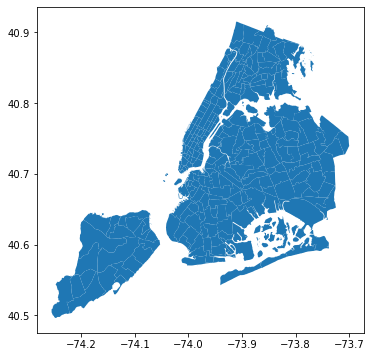

In [143]:
taxi_zones.plot();

# Ridehail Trip Data

Source: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [18]:
url = "https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2020-10.csv"

In [19]:
%%time
trips = pd.read_csv(url)

CPU times: user 10.7 s, sys: 3.01 s, total: 13.7 s
Wall time: 47.3 s


# Pickups per Taxi Zone

In [144]:
taxi_zones['location_id'] = taxi_zones['location_id'].astype(int)

In [145]:
pickups_per_zone = pd.DataFrame(trips.groupby('PULocationID').size()).reset_index()
pickups_per_zone.columns = ['location_id', 'pickups']

In [146]:
taxi_zones = pd.merge(taxi_zones, pickups_per_zone, how='left', on='location_id')

In [147]:
taxi_zones['area_sq_mile'] = taxi_zones['geometry'].to_crs(6933).area / 2.59e+6

In [148]:
taxi_zones['pickups_per_sq_mile'] = taxi_zones['pickups'] / taxi_zones['area_sq_mile']

In [149]:
taxi_zones = taxi_zones.dropna()

In [150]:
taxi_zones = taxi_zones.reset_index()

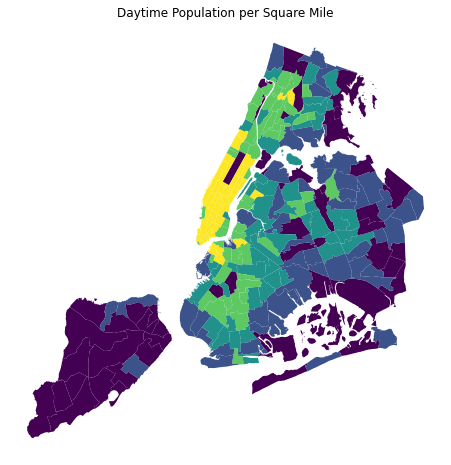

In [434]:
fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.to_crs(4326).plot(column='day_pop_per_sq_mile', ax=ax, scheme='quantiles')
plt.title("Daytime Population per Square Mile")
ax.axis('off');

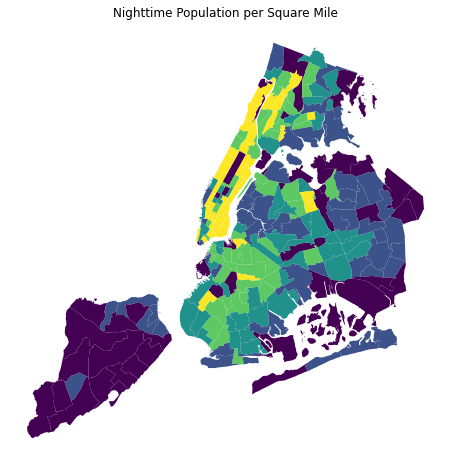

In [435]:
fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.to_crs(4326).plot(column='night_pop_per_sq_mile', ax=ax, scheme='quantiles')
plt.title("Nighttime Population per Square Mile")
ax.axis('off');

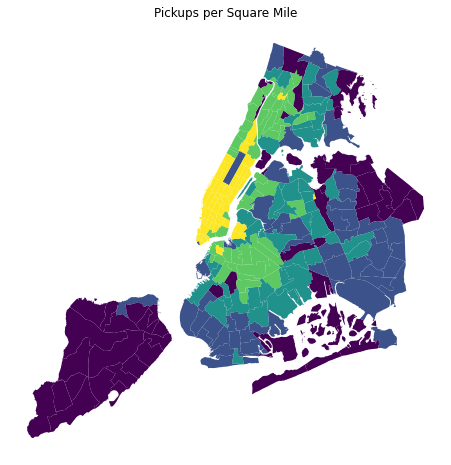

In [151]:
fig, ax = plt.subplots(figsize=(8,8))
taxi_zones.plot(column='pickups_per_sq_mile', ax=ax, scheme='quantiles')
plt.title("Pickups per Square Mile")
ax.axis('off');

# Population per Taxi Zone

Source: LandScan Daytime and Nighttime Population

In [152]:
from rasterstats import zonal_stats
import warnings
warnings.filterwarnings("ignore")

In [153]:
night_pop_path = "/Users/will/Documents/LandScan/LandScanConusNight.tif"

In [154]:
taxi_zones_night_pops = zonal_stats(taxi_zones, night_pop_path, stats='sum')

In [155]:
day_pop_path = "/Users/will/Documents/LandScan/LandScanConusDay.tif"

In [156]:
taxi_zones_day_pops = zonal_stats(taxi_zones, day_pop_path, stats='sum')

In [157]:
taxi_zones['night_pop'] = [i['sum'] for i in taxi_zones_night_pops]
taxi_zones['day_pop'] = [i['sum'] for i in taxi_zones_day_pops]

In [158]:
taxi_zones['night_pop_per_sq_mile'] = taxi_zones['night_pop'] / taxi_zones['area_sq_mile'] 
taxi_zones['day_pop_per_sq_mile'] = taxi_zones['day_pop'] / taxi_zones['area_sq_mile'] 

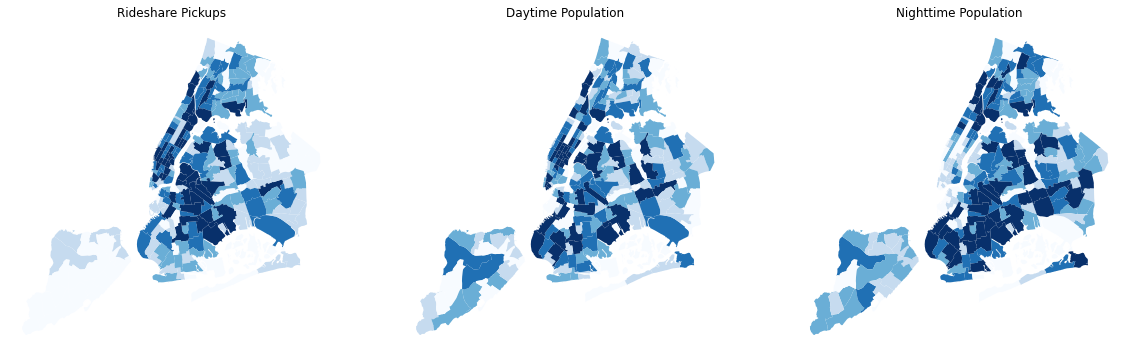

In [159]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20,12))
taxi_zones.plot(column='pickups', ax=ax1, scheme='quantiles', cmap='Blues')
taxi_zones.plot(column='day_pop', ax=ax2, scheme='quantiles', cmap='Blues')
taxi_zones.plot(column='night_pop', ax=ax3, scheme='quantiles', cmap='Blues')
ax1.set_title("Rideshare Pickups")
ax2.set_title("Daytime Population")
ax3.set_title("Nighttime Population")
for ax in [ax1, ax2, ax3]:
    ax.axis('off');

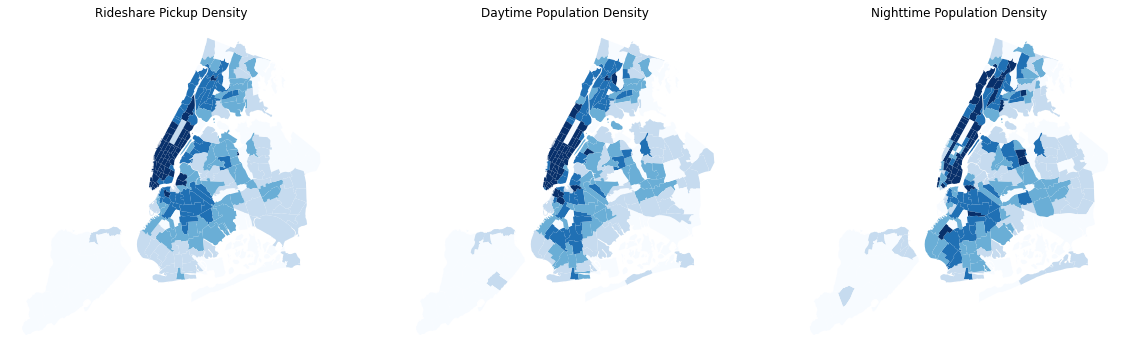

In [163]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20,12))
taxi_zones.plot(column='pickups_per_sq_mile', ax=ax1, scheme='quantiles', cmap='Blues')
taxi_zones.plot(column='day_pop_per_sq_mile', ax=ax2, scheme='quantiles', cmap='Blues')
taxi_zones.plot(column='night_pop_per_sq_mile', ax=ax3, scheme='quantiles', cmap='Blues')
ax1.set_title("Rideshare Pickup Density")
ax2.set_title("Daytime Population Density")
ax3.set_title("Nighttime Population Density")
for ax in [ax1, ax2, ax3]:
    ax.axis('off');

# Linear Regression with OLS

Pickups ~ Daytime Population + Nighttime Population + Is_Airport

In [183]:
import statsmodels.formula.api as smf

In [184]:
formula = "pickups ~ night_pop + day_pop + C(is_airport)"

In [185]:
m1 = smf.ols(formula, data=taxi_zones).fit()

In [186]:
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                pickups   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     87.53
Date:                Tue, 12 Apr 2022   Prob (F-statistic):           5.76e-39
Time:                        10:46:01   Log-Likelihood:                -3023.0
No. Observations:                 259   AIC:                             6054.
Df Residuals:                     255   BIC:                             6068.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           4926.2404   3392.769      1.452      0.148   -1755.175    1.16e+04
C(is_airport)[T.1]  4.919e+04   2.04e+04      2.405      0.017    8915.195    8.95e+04
night_pop              0.7700      0.080      9.603      0.000       0.612       0.928
day_pop                0.5900      0.060      9.827      0.000       0.472       0.708
==============================================================================
Omnibus:                       36.047   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.765
Skew:                           0.708   Prob(JB):                     9.60e-17
Kurtosis:                       5.197   Cond. No.                     6.61e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [187]:
# Predictions cannot be negative: clip them to zero
taxi_zones['m1_predictions'] = m1.fittedvalues.clip(lower=0).astype(int)

# Calculate residuals = actuals minus predictions
taxi_zones['m1_residuals'] = taxi_zones['pickups'] - taxi_zones['m1_predictions']

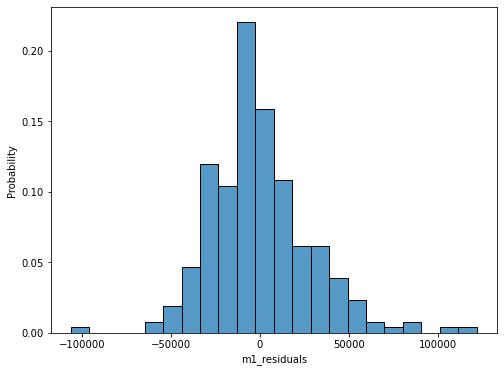

In [189]:
sns.histplot(taxi_zones['m1_residuals'], stat='probability');

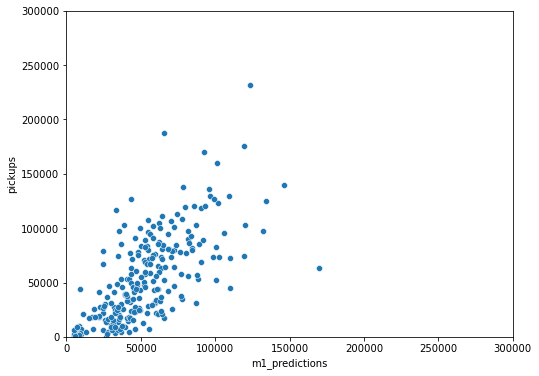

In [190]:
sns.scatterplot(y=taxi_zones['pickups'], x=taxi_zones['m1_predictions'])
plt.ylim(0, 300000)
plt.xlim(0, 300000);

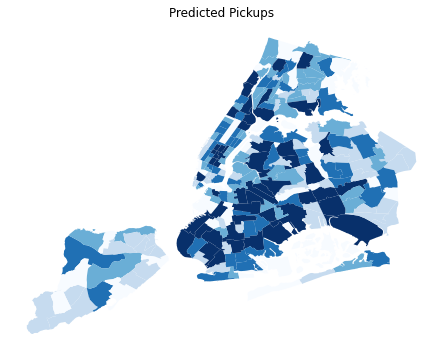

In [191]:
ax = taxi_zones.plot(column='m1_predictions', scheme='quantiles', cmap='Blues')
plt.title('Predicted Pickups')
ax.axis('off');

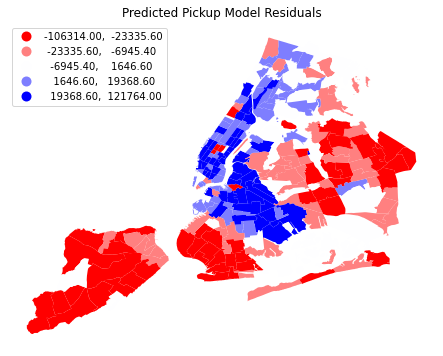

In [192]:
ax = taxi_zones.plot(column='m1_residuals', scheme='quantiles', cmap='bwr_r', 
                                             legend=True, legend_kwds={'loc': 'upper left'})
plt.title('Predicted Pickup Model Residuals')
ax.axis('off');

# Linear Regression Spatial Diagnostics

Re-run OLS linear regression, this time using PySAL with spatial diagnostics enabled.

In [193]:
taxi_zones = taxi_zones.to_crs(6933)

First, need to create spatial weigths

In [194]:
from libpysal import weights
from pysal.explore import esda

In [195]:
# create spatial weights
w = weights.Queen.from_dataframe(taxi_zones)

# Fill in Islands with KNN weights
w_knn = weights.KNN.from_dataframe(taxi_zones,k=2)
w = weights.attach_islands(w, w_knn)

# Row standardise weights
w.transform = 'R'

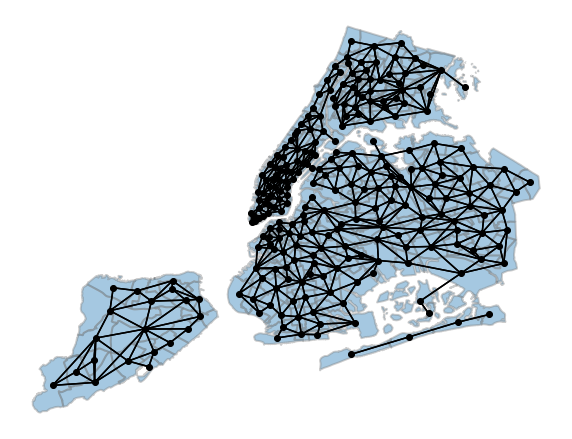

In [438]:
# map the spatial weights
f, ax = plt.subplots(figsize=(10, 10))
taxi_zones.plot(alpha=0.4, edgecolor='gray', linewidth=2, ax=ax)
w.plot(taxi_zones[['geometry']], ax=ax)
ax.set_axis_off()
plt.show()

Fit an OLS Model with Spatial Diagnostics Enabled

In [197]:
from pysal.model import spreg

In [199]:
target_variable = ['pickups']
feature_variables = ['night_pop', 'day_pop', 'is_airport']

m2 = spreg.OLS(
    
    # Target variable
    taxi_zones[target_variable].values, 
    
    # Feature variables
    taxi_zones[feature_variables].values,
    
    # Target variable name
    name_y = target_variable[0], 
    
    # Feature variable names
    name_x = feature_variables,
    
    # Specify the weights
    w = w,
    
    # Enable spatial diagnostics
    spat_diag=True
)

In [200]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     pickups                Number of Observations:         259
Mean dependent var  :  51308.0502                Number of Variables   :           4
S.D. dependent var  :  40488.3985                Degrees of Freedom    :         255
R-squared           :      0.5073
Adjusted R-squared  :      0.5015
Sum squared residual:208367039915.772                F-statistic           :     87.5325
Sigma-square        :817125646.729                Prob(F-statistic)     :   5.763e-39
S.E. of regression  :   28585.410                Log likelihood        :   -3022.998
Sigma-square ML     :804505945.621                Akaike info criterion :    6053.997
S.E of regression ML:  28363.8140                Schwarz criterion     :    6068.224

-----------------------------------------------------------------------

    - OLS Regression -> LM Diagnostics
    - Is LM-Error Significant? Yes, pvalue = 0.0
    - Is LM-Lag Significant? Yes, pvalue = 0.0

    Both the LM-Error and LM-Lag tests are significant.

    - Is Robust LM-Error Significant? Yes, pvalue = 0.0
    - Is Robust LM-Lag Significant? No, pvalue = 0.10

    Only the Robus LM-Error is significant. So, use Spatial Error Model.

# Spatial Error Model

In [ ]:
from pysal.model import spreg

In [234]:
target_variable = ['pickups']
feature_variables = ['night_pop', 'day_pop', 'is_airport']

m3 = spreg.ML_Error(
    
    # Target variable
    taxi_zones[target_variable].values, 
    
    # Feature variables
    taxi_zones[feature_variables].values,
    
    # Target variable name
    name_y = target_variable[0], 
    
    # Feature variable names
    name_x = feature_variables,
    
    # Specify the weights
    w = w
)

In [235]:
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     pickups                Number of Observations:         259
Mean dependent var  :  51308.0502                Number of Variables   :           4
S.D. dependent var  :  40488.3985                Degrees of Freedom    :         255
Pseudo R-squared    :      0.4596
Sigma-square ML     :373657808.015                Log likelihood        :   -2943.351
S.E of regression   :   19330.230                Akaike info criterion :    5894.702
                                                 Schwarz criterion     :    5908.929

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------------------------------------------

In [236]:
# Predictions cannot be negative: clip them to zero
taxi_zones['m3_predictions'] = pd.Series(m3.predy[:,0]).clip(lower=0).astype(int)

# Calculate residuals = actuals minus predictions
taxi_zones['m3_residuals'] = taxi_zones['pickups'] - taxi_zones['m3_predictions']

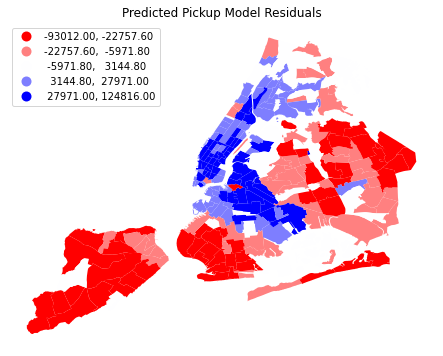

In [246]:
ax = taxi_zones.plot(column='m3_residuals', scheme='quantiles', cmap='bwr_r', 
                                             legend=True, legend_kwds={'loc': 'upper left'})
plt.title('Predicted Pickup Model Residuals')
ax.axis('off');

# Spatial Lag Model

For demonstration purposes, fit a spatial lag model.

In [237]:
target_variable = ['pickups']
feature_variables = ['night_pop', 'day_pop', 'is_airport']

m4 = spreg.ML_Lag(
    
    # Target variable
    taxi_zones[target_variable].values, 
    
    # Feature variables
    taxi_zones[feature_variables].values,
    
    # Target variable name
    name_y = target_variable[0], 
    
    # Feature variable names
    name_x = feature_variables,
    
    # Specify the weights
    w = w
)

In [238]:
print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     pickups                Number of Observations:         259
Mean dependent var  :  51308.0502                Number of Variables   :           5
S.D. dependent var  :  40488.3985                Degrees of Freedom    :         254
Pseudo R-squared    :      0.6868
Spatial Pseudo R-squared:  0.4751
Sigma-square ML     :512697326.639                Log likelihood        :   -2972.500
S.E of regression   :   22642.821                Akaike info criterion :    5955.000
                                                 Schwarz criterion     :    5972.784

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------------

In [239]:
# Predictions cannot be negative: clip them to zero
taxi_zones['m4_predictions'] = pd.Series(m4.predy[:,0]).clip(lower=0).astype(int)

# Calculate residuals = actuals minus predictions
taxi_zones['m4_residuals'] = taxi_zones['pickups'] - taxi_zones['m4_predictions']

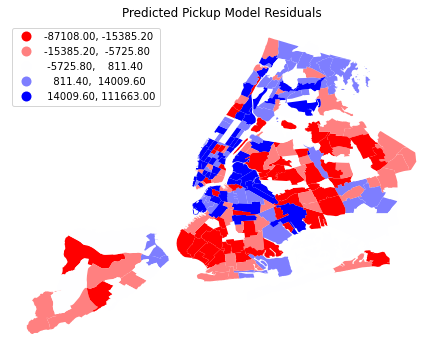

In [247]:
ax = taxi_zones.plot(column='m4_residuals', scheme='quantiles', cmap='bwr_r', 
                                             legend=True, legend_kwds={'loc': 'upper left'})
plt.title('Predicted Pickup Model Residuals')
ax.axis('off');

# Combined Spatial Error + Lag Model

In [443]:
target_variable = ['pickups']
feature_variables = ['night_pop', 'day_pop', 'is_airport']

m_combo = spreg.GM_Combo(
    
    # Target variable
    taxi_zones[target_variable].values, 
    
    # Feature variables
    taxi_zones[feature_variables].values,
    
    # Target variable name
    name_y = target_variable[0], 
    
    # Feature variable names
    name_x = feature_variables,
    
    # Specify the weights
    w = w
)

In [444]:
print(m_combo.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED TWO STAGE LEAST SQUARES
-------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     pickups                Number of Observations:         259
Mean dependent var  :  51308.0502                Number of Variables   :           5
S.D. dependent var  :  40488.3985                Degrees of Freedom    :         254
Pseudo R-squared    :      0.5000
Spatial Pseudo R-squared:  0.4591

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      88.4051545    9143.4076042       0.0096687       0.9922856
           night_pop       1.0306877       0.0775580      13.2892570       0.0000000
             day_pop       0.3287128 

# OLS Regimes Model

Using the NYC Boroughs to define regimes.

In [276]:
target_variable = ['pickups']
feature_variables = ['night_pop', 'day_pop', 'is_airport']
regimes = taxi_zones['borough']

m_OLS_regimes = spreg.OLS_Regimes(
    
    # Target variable
    y = taxi_zones[target_variable].values, 
    
    # Feature variables
    x = taxi_zones[feature_variables].values,
    
    # Specify regimes
    regimes = regimes,
    
    # Target variable name
    name_y = target_variable[0], 
    
    # Feature variable names
    name_x = feature_variables,
    
    # Specify the weights
    w = w,
    
    # Enable spatial diagnostics
    spat_diag=True
)

In [277]:
print(m_OLS_regimes.summary)

REGRESSION
----------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME Bronx
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Bronx_pickups                Number of Observations:          43
Mean dependent var  :  47607.7209                Number of Variables   :           3
S.D. dependent var  :  26494.4739                Degrees of Freedom    :          40
R-squared           :      0.8564
Adjusted R-squared  :      0.8492
Sum squared residual:4233201962.801                F-statistic           :    119.2903
Sigma-square        :105830049.070                Prob(F-statistic)     :   1.387e-17
S.E. of regression  :   10287.373                Log likelihood        :    -456.722
Sigma-square ML     :98446557.274                Akaike info criterion :     919.445
S.E of regression ML:   9922.0238                Schwarz criterion     :     924.728

--------------------

In [278]:
# Predictions cannot be negative: clip them to zero
taxi_zones['m_ols_regimes_predictions'] = pd.Series(m_OLS_regimes.predy[:,0]).clip(lower=0).astype(int)

# Calculate residuals = actuals minus predictions
taxi_zones['m_ols_regimes_residuals'] = taxi_zones['pickups'] - taxi_zones['m_ols_regimes_predictions']

# Spatial Error Regimes Model

In [279]:
target_variable = ['pickups']
feature_variables = ['night_pop', 'day_pop']
regimes = taxi_zones['borough']

m_error_regimes = spreg.ML_Error_Regimes(
    
    # Target variable
    y = taxi_zones[target_variable].values, 
    
    # Feature variables
    x = taxi_zones[feature_variables].values,
    
    # Specify regimes
    regimes = regimes,
    
    # Target variable name
    name_y = target_variable[0], 
    
    # Feature variable names
    name_x = feature_variables,
    
    # Specify the weights
    w = w
)

In [280]:
# Predictions cannot be negative: clip them to zero
taxi_zones['m_error_regimes_predictions'] = pd.Series(m_error_regimes.predy[:,0]).clip(lower=0).astype(int)

# Calculate residuals = actuals minus predictions
taxi_zones['m_error_regimes_residuals'] = taxi_zones['pickups'] - taxi_zones['m_error_regimes_predictions']

# Spatial Lag Regimes Model

In [281]:
target_variable = ['pickups']
feature_variables = ['night_pop', 'day_pop']
regimes = taxi_zones['borough']

m_lag_regimes = spreg.ML_Lag_Regimes(
    
    # Target variable
    y = taxi_zones[target_variable].values, 
    
    # Feature variables
    x = taxi_zones[feature_variables].values,
    
    # Specify regimes
    regimes = regimes,
    
    # Target variable name
    name_y = target_variable[0], 
    
    # Feature variable names
    name_x = feature_variables,
    
    # Specify the weights
    w = w
)

In [282]:
# Predictions cannot be negative: clip them to zero
taxi_zones['m_lag_regimes_predictions'] = pd.Series(m_lag_regimes.predy[:,0]).clip(lower=0).astype(int)

# Calculate residuals = actuals minus predictions
taxi_zones['m_lag_regimes_residuals'] = taxi_zones['pickups'] - taxi_zones['m_lag_regimes_predictions']

In [285]:
print(m_lag_regimes.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG - REGIMES (METHOD = full)
---------------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     pickups                Number of Observations:         259
Mean dependent var  :  51308.0502                Number of Variables   :          16
S.D. dependent var  :  40488.3985                Degrees of Freedom    :         243
Pseudo R-squared    :      0.7137
Spatial Pseudo R-squared:  0.6044
Sigma-square ML     :467752056.431                Log likelihood        :   -2956.868
S.E of regression   :   21627.576                Akaike info criterion :    5945.737
                                                 Schwarz criterion     :    6002.646

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------

Compare the distribution of model residuals for all models trained thus far.

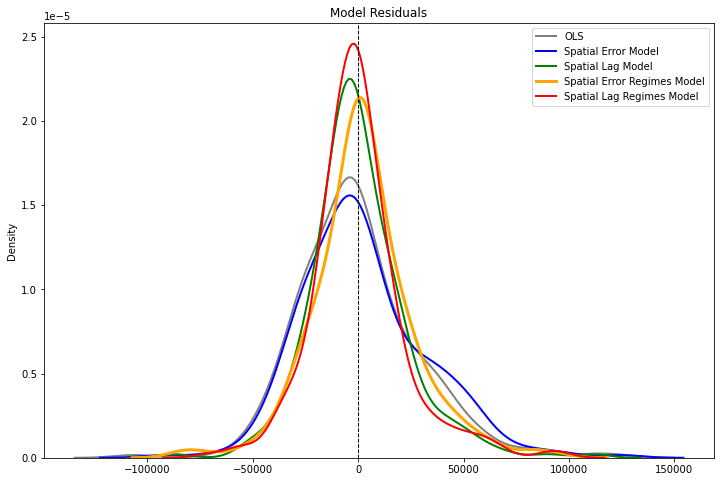

In [446]:
fig, ((ax1)) = plt.subplots(1, 1, figsize=(12,8))
sns.kdeplot(m2.u[:,0], ax=ax1, color='gray',linewidth=2, label="OLS")
sns.kdeplot(m3.u[:,0], ax=ax1, color='blue',linewidth=2, label="Spatial Error Model")
sns.kdeplot(m4.u[:,0], ax=ax1, color='green',linewidth=2, label="Spatial Lag Model")
sns.kdeplot(m_error_regimes.u[:,0], ax=ax1, color='orange',linewidth=3, label="Spatial Error Regimes Model")
sns.kdeplot(m_lag_regimes.u[:,0], ax=ax1, color='red',linewidth=2, label="Spatial Lag Regimes Model")
ax1.axvline(0, color='black', linestyle='--', linewidth=1)
plt.legend(loc='upper right')
plt.title("Model Residuals");

# Geographic Weighted Regression

Demonstrate a GWR model to predict rideshare trips based on daytime and nighttime population, allowing for model parameters with vary with space.

In [408]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

In [409]:
taxi_zones['X'] = taxi_zones['geometry'].centroid.x
taxi_zones['Y'] = taxi_zones['geometry'].centroid.y

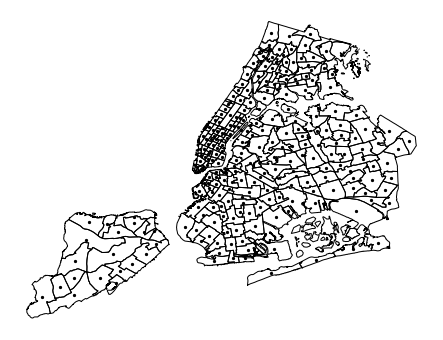

In [410]:
ax = taxi_zones.plot(facecolor='none')
taxi_zones.centroid.plot(ax=ax, c='black', markersize=5)
ax.axis('off');

In [411]:
target_variable = ['pickups']
feature_variables = ['night_pop', 'day_pop']

In [412]:
y = taxi_zones[target_variable[0]].values.reshape((-1,1))

In [413]:
X = taxi_zones[feature_variables].values

In [414]:
u = taxi_zones['X']
v = taxi_zones['Y']
coords = list(zip(u,v))

In [417]:
#Calibrate GWR model
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search(bw_min=5)
print(gwr_bw)

35.0


In [418]:
gwr_results = GWR(coords, y, X, gwr_bw).fit()

In [419]:
gwr_results.params[0:5]

array([[-8.93568224e+03,  9.67917762e-02,  1.90538165e+00],
       [ 9.67687032e+02,  6.96957324e-01,  7.58403734e-01],
       [ 1.15337280e+04,  1.83422071e+00,  6.60105360e-01],
       [-3.99710583e+03,  2.64708784e-01,  3.28461081e-01],
       [-6.17651698e+03,  5.66268165e-01,  2.44518394e-01]])

In [447]:
gwr_results.localR2[0:5]

array([[0.93552059],
       [0.94377622],
       [0.50719544],
       [0.71947763],
       [0.80614829]])

In [448]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 259
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       213094449742.266
Log-likelihood:                                                   -3025.904
AIC:                                                               6057.807
AICc:                                                              6059.965
BIC:                                                           213094448319.718
R2:                                                                   0.496
Adj. R2:                                                              0.492

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------

View the GWR results.

In [422]:
taxi_zones['gwr_params_intercept'] = gwr_results.params[:,0]

In [423]:
taxi_zones['gwr_params_night_pop'] = gwr_results.params[:,1]

In [424]:
taxi_zones['gwr_params_day_pop'] = gwr_results.params[:,2]

In [425]:
taxi_zones['gwr_local_rsquared'] = gwr_results.localR2

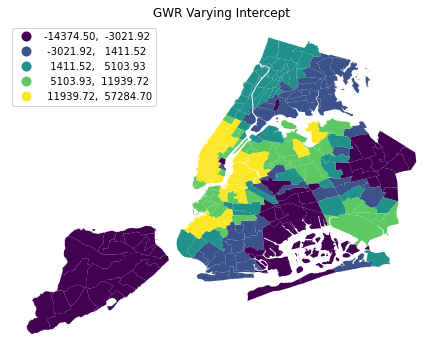

In [426]:
ax = taxi_zones.plot(column='gwr_params_intercept', scheme='quantiles', cmap='viridis', 
                                             legend=True, legend_kwds={'loc': 'upper left'})
plt.title('GWR Varying Intercept')
ax.axis('off');

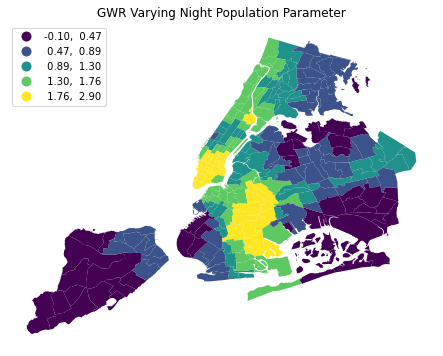

In [427]:
ax = taxi_zones.plot(column='gwr_params_night_pop', scheme='fisher_jenks', cmap='viridis', 
                                             legend=True, legend_kwds={'loc': 'upper left'})
plt.title('GWR Varying Night Population Parameter')
ax.axis('off');

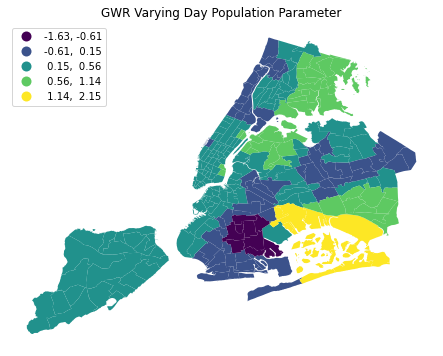

In [428]:
ax = taxi_zones.plot(column='gwr_params_day_pop', scheme='fisher_jenks', cmap='viridis', 
                                             legend=True, legend_kwds={'loc': 'upper left'})
plt.title('GWR Varying Day Population Parameter')
ax.axis('off');

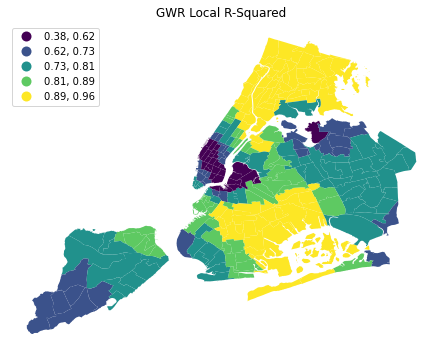

In [431]:
ax = taxi_zones.plot(column='gwr_local_rsquared', scheme='fisher_jenks', cmap='viridis', 
                                             legend=True, legend_kwds={'loc': 'upper left'})
plt.title('GWR Local R-Squared')
ax.axis('off');

In [ ]:
taxi_zones.to_file("regression_results.geojson")